# Flow-Flow integration of (Nunez et al. and Kreutmair et al.)

In [1]:
import cytovi
import anndata as ad
import pandas as pd
import numpy as np
import os
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import readfcs

/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_use_gpu' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
figure_dir = '../figures/figure3/'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["savefig.dpi"] = 300

sc.settings.figdir = figure_dir
sc.set_figure_params(dpi_save = 300)

# Annotate Kreutmair et al.

In [9]:
# Read .fcs filee and preprocess
adata_kreutmair = readfcs.read('../data/raw/Spectral flow/Kreutmair/surface/2_CD45pos_clean.fcs')
adata_kreutmair.layers['raw'] = adata_kreutmair.X
cytovi.pp.arcsinh(adata_kreutmair, global_scaling_factor = 2000)
cytovi.pp.scale(adata_kreutmair)
adata_kreutmair = cytovi.pp.subsample(adata_kreutmair, n_obs=100000)

In [18]:
# compute umap and leiden clusters
adata_kreutmair.X = adata_kreutmair.layers['scaled']
sc.pp.neighbors(adata_kreutmair)
sc.tl.umap(adata_kreutmair)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


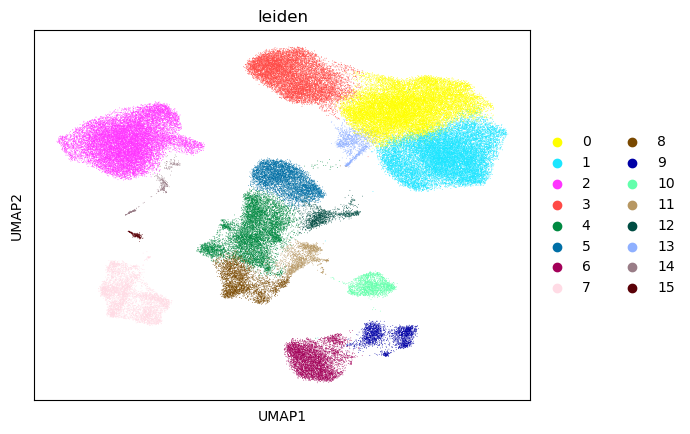

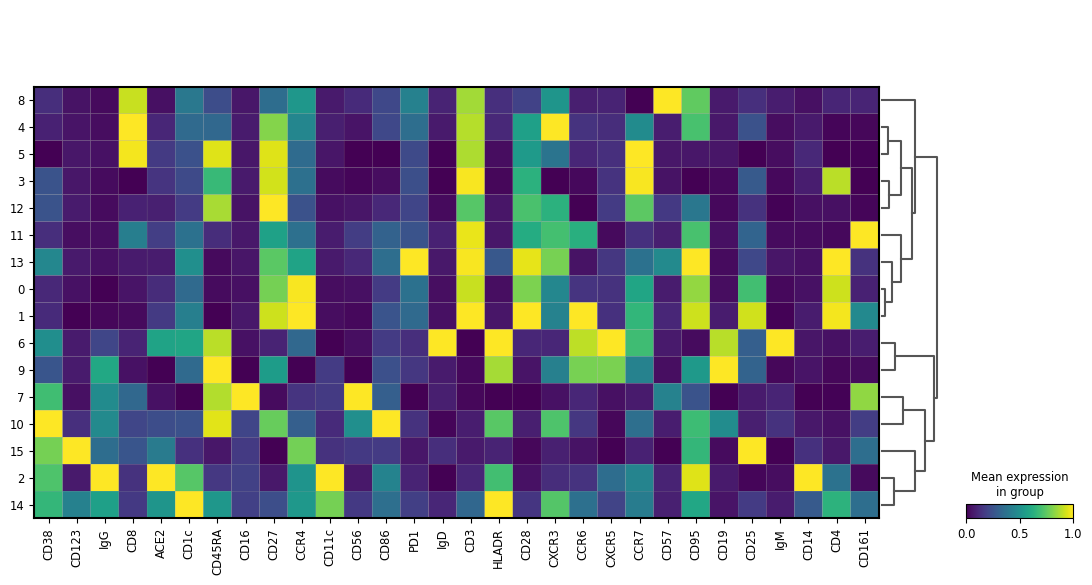

In [21]:
# leiden and plotting
sc.tl.leiden(adata_kreutmair, resolution = 0.5)
sc.pl.umap(adata_kreutmair, color = 'leiden')
sc.pl.matrixplot(adata_kreutmair, var_names=adata_kreutmair.var_names, dendrogram=True, groupby='leiden', use_raw = False, layer = 'scaled', standard_scale='var')

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


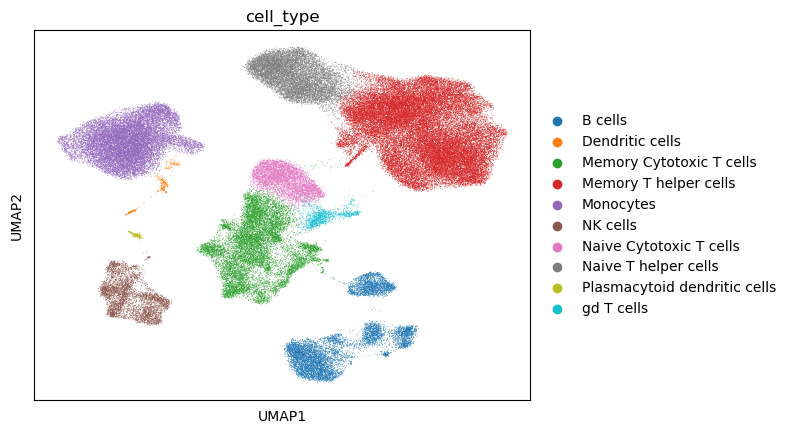

In [23]:
# annotate cells
annot_dict = {
    '8': 'Memory Cytotoxic T cells',
    '4': 'Memory Cytotoxic T cells',
    '5': 'Naive Cytotoxic T cells',
    '3': 'Naive T helper cells',
    '12': 'gd T cells',
    '11': 'Memory Cytotoxic T cells',
    '13': 'Memory T helper cells',
    '0': 'Memory T helper cells',
    '1': 'Memory T helper cells',
    '6': 'B cells',
    '9': 'B cells',
    '7': 'NK cells',
    '10': 'B cells',
    '15': 'Plasmacytoid dendritic cells',
    '2': 'Monocytes',
    '14': 'Dendritic cells'
}
adata_kreutmair.obs['cell_type'] = adata_kreutmair.obs['leiden'].map(annot_dict)

sc.pl.umap(adata_kreutmair, color = 'cell_type')

In [24]:
# save adata
adata_kreutmair.write_h5ad('../data/raw/Spectral flow/Kreutmair/surface/2024-08-23_sample2_kreutmair_annotated.h5ad')

# load nunez, harmonize labels and train model

In [25]:
# load data
adata_nunez = ad.read_h5ad('../data/raw/Spectral flow/Nunez/For Chiquito/annotated/2024-01-24_norm_sample_batch1_ann.h5ad')

In [31]:
mapping_nunez = {
    'B cells': 'B cells',
    'CD56dim NK cells': 'NK cells',
    'CD56high NK cells': 'NK cells',
    'Classical monocytes': 'Monocytes',
    'Cytotoxic memory T cells': 'Memory Cytotoxic T cells',
    'Dendritic cells': 'Dendritic cells',
    'KLRG1+ Th cells': 'Memory T helper cells',
    'KLRG1+ cytotoxic memory T cells': 'Memory Cytotoxic T cells',
    'Memory Th cells': 'Memory T helper cells',
    'Naive Th cells': 'Naive T helper cells',
    'Naive cytotoxic T cells': 'Naive Cytotoxic T cells',
    'Non-classical monocytes': 'Monocytes',
    'Plasmacytoid dendritic cells': 'Plasmacytoid dendritic cells',
    'Regulatory T cells': 'Memory T helper cells',
    'Unknown': 'Unknown',
    'gd T cells': 'gd T cells'
}

mapping_kreutmair = {
    'B cells': 'B cells',
    'Dendritic cells': 'Dendritic cells',
    'Memory Cytotoxic T cells': 'Memory Cytotoxic T cells',
    'Memory T helper cells': 'Memory T helper cells',
    'Monocytes': 'Monocytes', 
    'NK cells': 'NK cells', 
    'Naive Cytotoxic T cells': 'Naive Cytotoxic T cells',
    'Naive T helper cells': 'Naive T helper cells',
    'Plasmacytoid dendritic cells': 'Plasmacytoid dendritic cells',
    'gd T cells': 'gd T cells'
}

adata_nunez.obs['harmonized_labels'] = adata_nunez.obs['cell_type'].map(mapping_nunez).astype('category')
adata_kreutmair.obs['harmonized_labels'] = adata_kreutmair.obs['cell_type'].map(mapping_kreutmair).astype('category')

In [51]:
# remove vars with unspecific/problematic staining patterns
rm_vars_nunez = ['CXCR3', 'PD1']
rm_vars_kreutmair = ['CD1c']

adata_nunez = adata_nunez[:, [var for var in adata_nunez.var_names if var not in rm_vars_nunez]].copy()
adata_kreutmair = adata_kreutmair[:, [var for var in adata_kreutmair.var_names if var not in rm_vars_kreutmair]].copy()

In [52]:
# combine datasets
adata = cytovi.pp.merge_batches([adata_nunez, adata_kreutmair])

Not all proteins are detected across all batches. Will generate nan_layer for imputation of missing proteins. 
Backbone markers: CCR4, CCR7, CD123, CD14, CD16, CD19, CD27, CD3, CD38, CD4, CD45RA, CD56, CD8, CD95, HLADR


In [54]:
# train model
train_kwargs = {
        'max_epochs': 50,
        'n_epochs_kl_warmup': 10}

        
cytovi.CytoVI.setup_anndata(
    adata,
    layer="scaled",
    batch_key='batch',
    labels_key='harmonized_labels'
)

model = cytovi.CytoVI(adata)
model.train(**train_kwargs)

Found nan_layer in adata. Will register nan_layer for missing marker imputation.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/50: 100%|██████████| 50/50 [19:53<00:00, 22.05s/it, v_num=1, train_loss_step=-45.6, train_loss_epoch=-48.7]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [19:53<00:00, 23.86s/it, v_num=1, train_loss_step=-45.6, train_loss_epoch=-48.7]


In [57]:
# save model to disk
model.save('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/models/imputation_eval/2024-08-23_nunez_kreutmair_200k', overwrite=True)

Text(0, 0.5, 'elbo_validation')

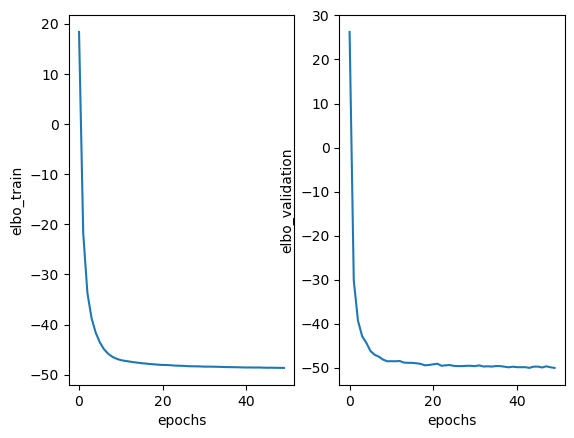

In [55]:
# check convergance
plt.subplot(1, 2, 1)
plt.plot(model.history['elbo_train'])
plt.xlabel('epochs')
plt.ylabel('elbo_train')

plt.subplot(1, 2, 2)
plt.plot(model.history['elbo_validation'])
plt.xlabel('epochs')
plt.ylabel('elbo_validation')

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


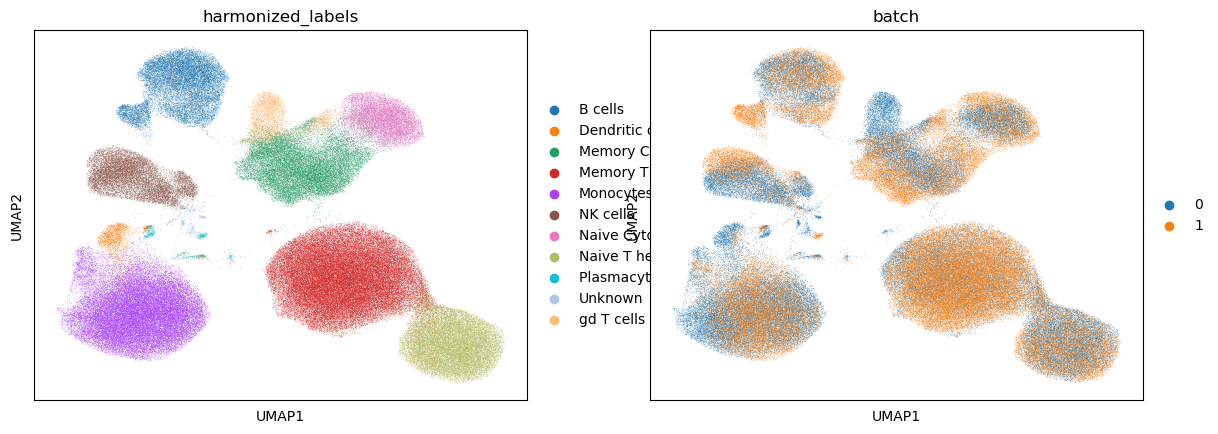

In [56]:
# compute umap and cluster CytoVI latent space
adata.obsm["X_CytoVI"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_CytoVI")
sc.tl.umap(adata)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


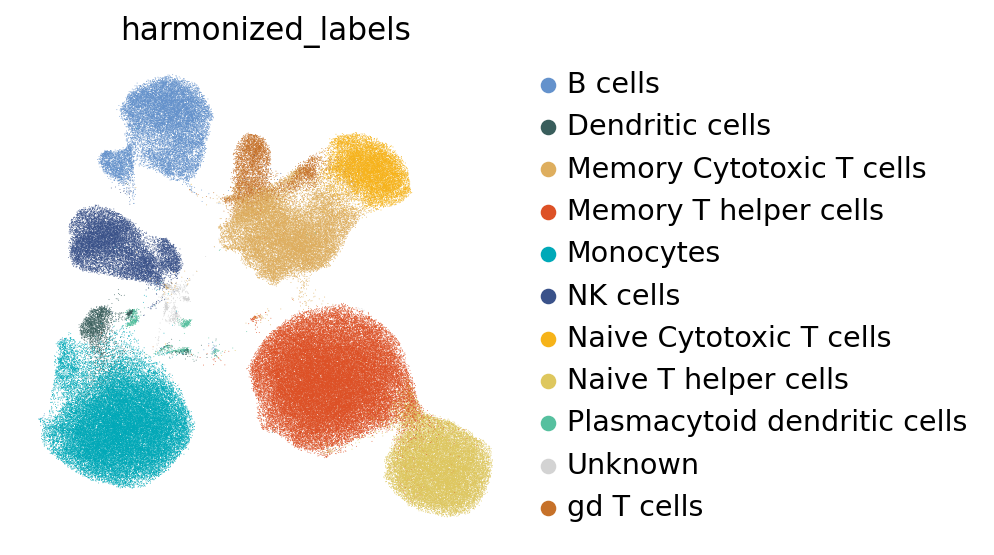

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


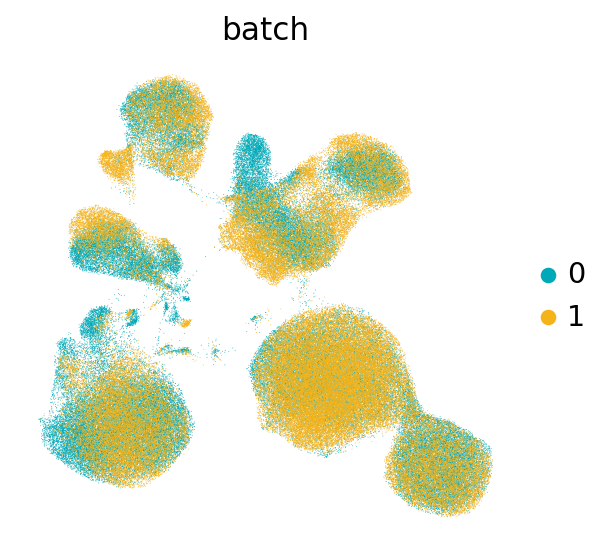

In [67]:
# plot data
cell_type_colors = {
    'B cells': '#6492CC', 
    'Dendritic cells': '#395E5C',  
    'Memory Cytotoxic T cells': '#DEAE5E', 
    'Memory T helper cells': '#DD5126', 
    'Monocytes': '#00A9B8', 
    'NK cells': '#3A528A', 
    'Naive Cytotoxic T cells': '#F6B319', 
    'Naive T helper cells': '#DEC75E', 
    'Plasmacytoid dendritic cells': '#56C09F', 
    'Unknown': 'lightgrey', 
    'gd T cells': '#C67129' 
}

sc.pl.umap(adata, color=["harmonized_labels"], palette = cell_type_colors, frameon = False, save ='flow_multi_panel_umap_cell_types.png')

batch_colors = ['#00A9B8', '#F6B319']
sc.pl.umap(adata, color = ['batch'], palette = batch_colors, frameon = False, save = 'flow_multi_panel_umap_batch.png')

In [58]:
# impute missing markers
adata.layers['imputed'] = model.get_normalized_expression(adata, n_samples = 10)

detected missing proteins between batches - will impute missing markers


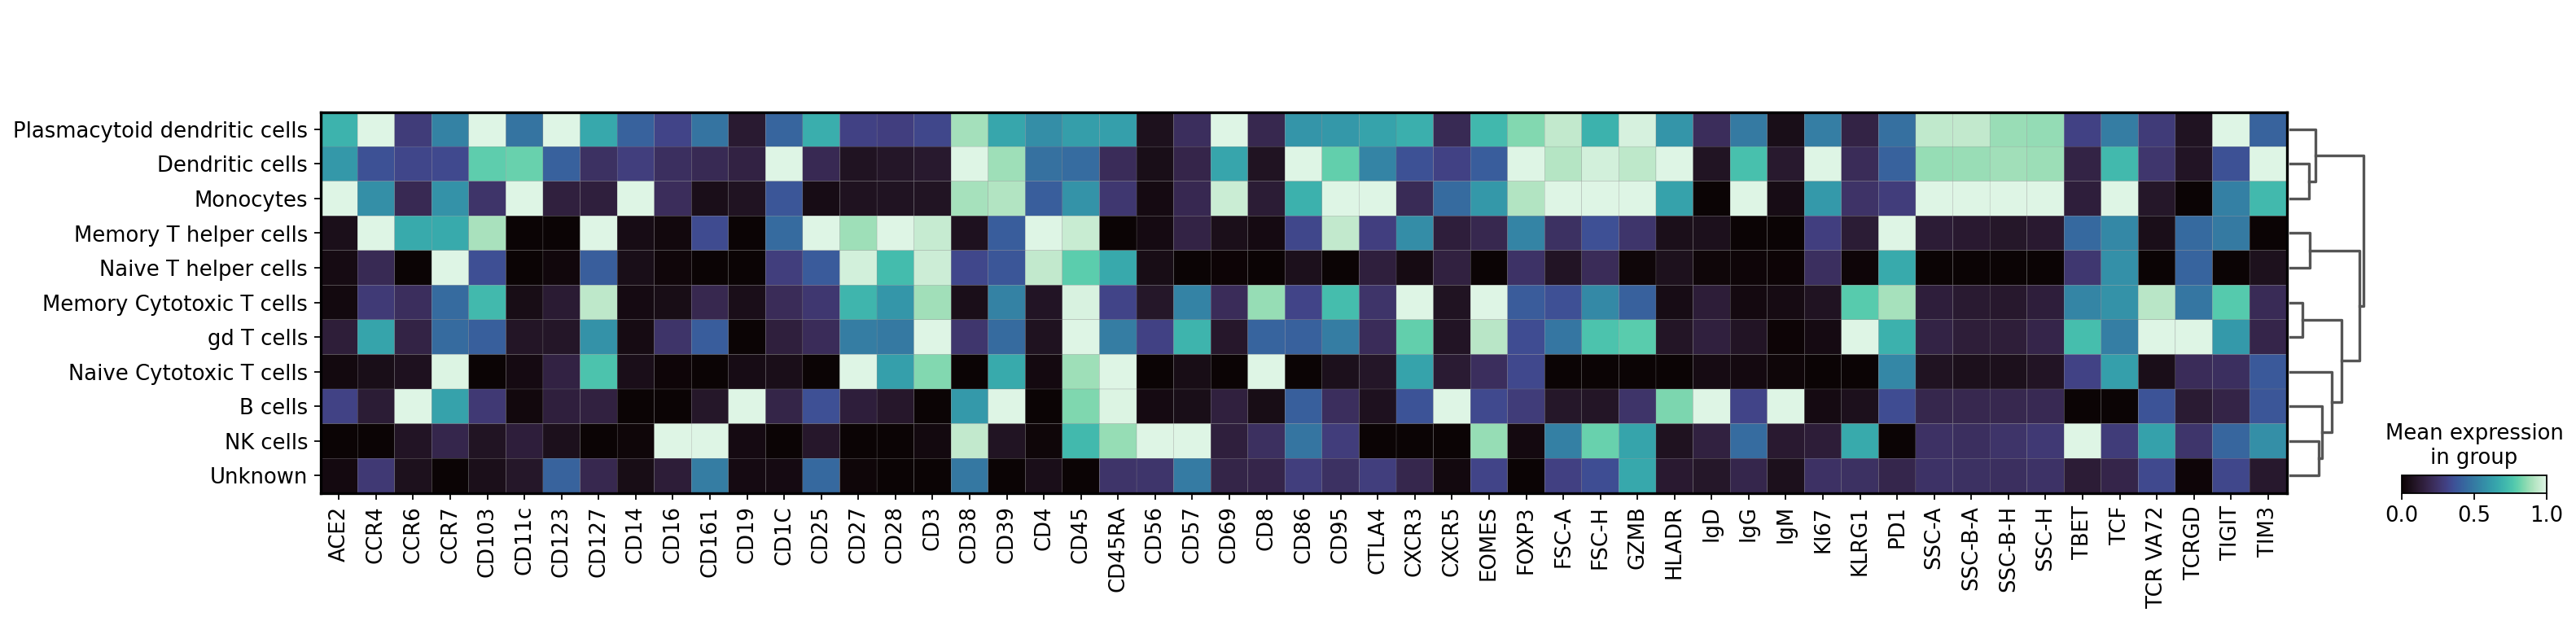

In [69]:
sc.pl.matrixplot(adata, var_names=adata.var_names, dendrogram=True, groupby='harmonized_labels', use_raw = False, layer = 'imputed', cmap = 'mako', standard_scale='var', save = 'flow_imputation.pdf')

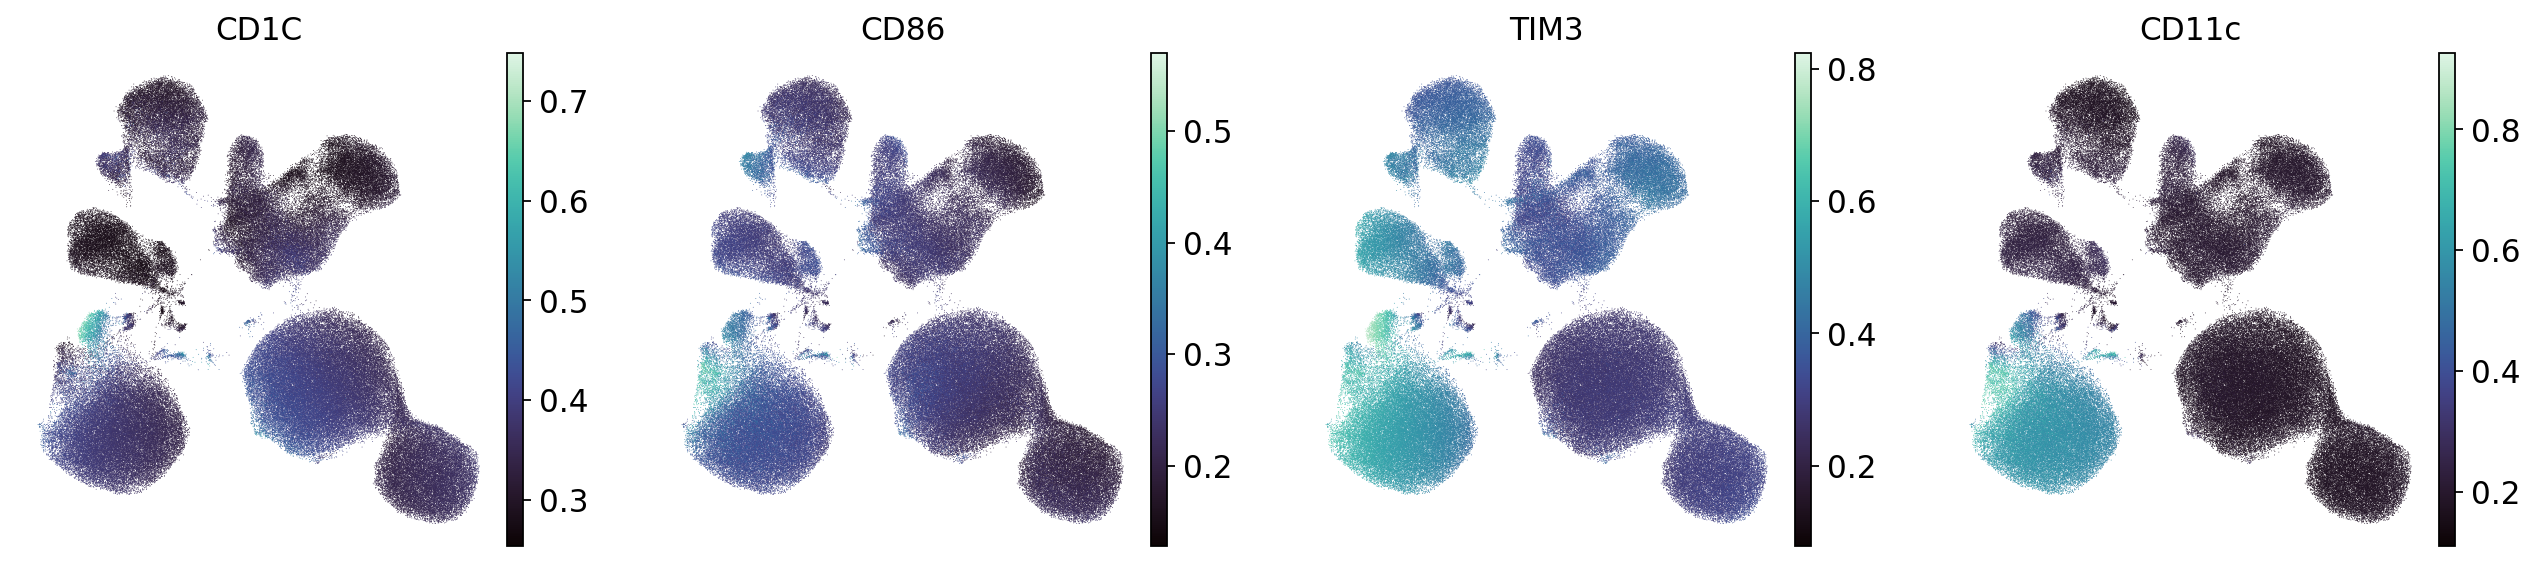

In [73]:
sc.pl.umap(adata, color = ['CD1C', 'CD86', 'TIM3', 'CD11c'], cmap='mako', frameon=False, layer='imputed', save = 'flow_imputation_CD1c_CD86_TIM3_CD11c_overlay.png')

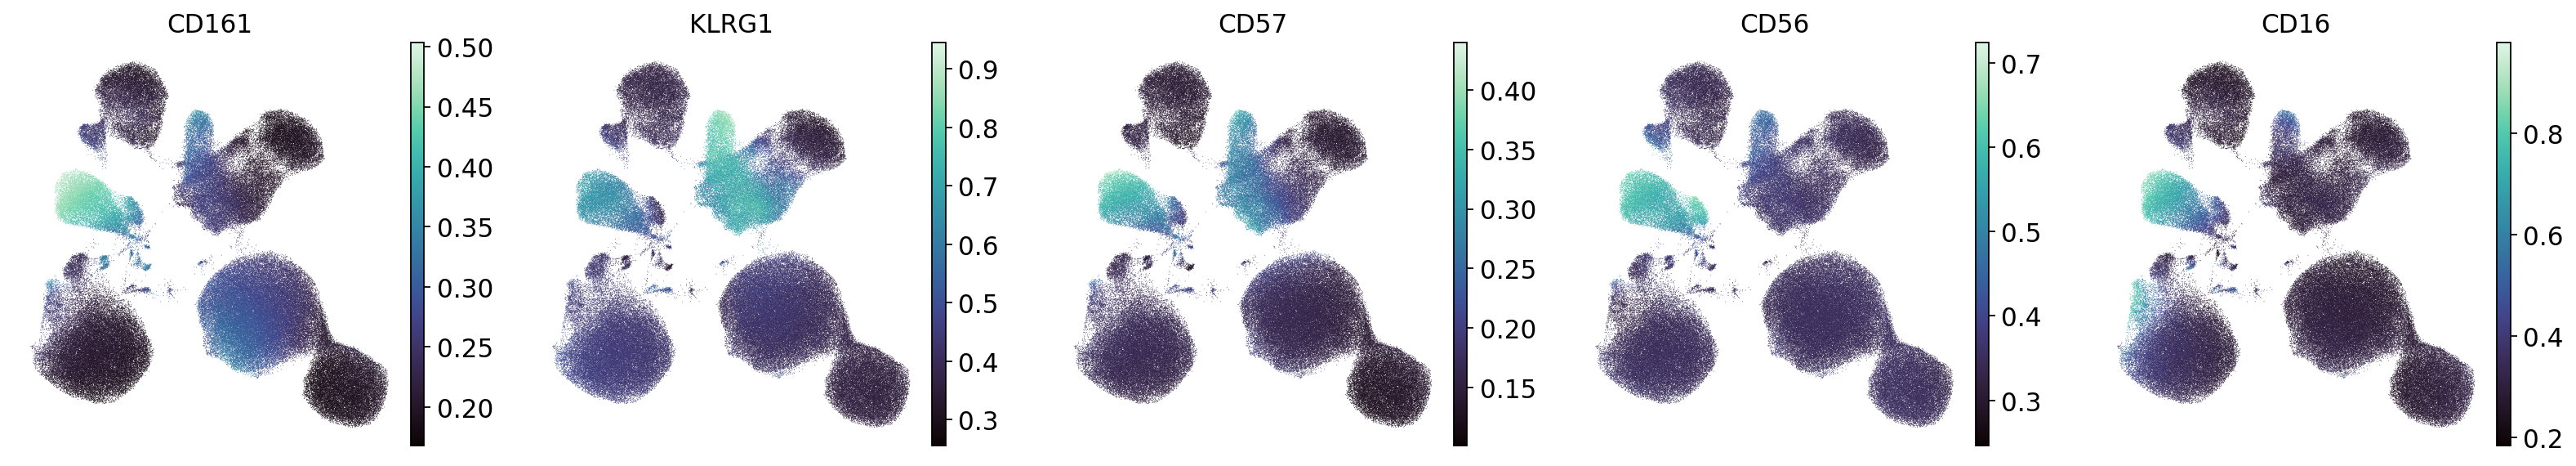

In [78]:
sc.pl.umap(adata, color = ['CD161', 'KLRG1', 'CD57', 'CD56', 'CD16'], cmap='mako', frameon=False, layer='imputed', ncols = 5, save = 'flow_imputation_NKcells_overlay.png')

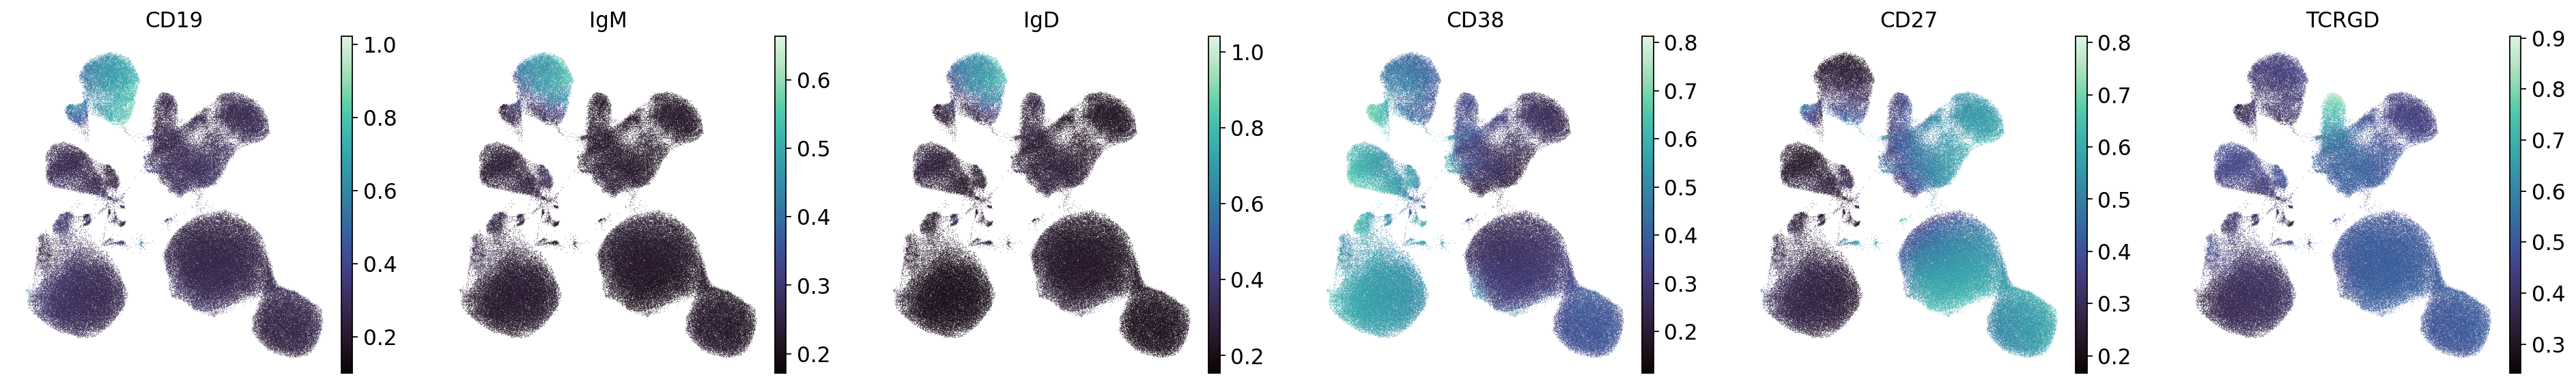

In [8]:
sc.pl.umap(adata, color = ['CD19', 'IgM', 'IgD', 'CD38', 'CD27', 'TCRGD'], cmap='mako', frameon=False, layer='imputed', ncols = 6, save = 'flow_imputation_plasmablasts_overlay.png')

In [70]:
# save anndata
adata.write_h5ad('../data/2024-06-14_imputation_eval_batch/2024-08-23_kreutmair_nunez_annotated_imputed.h5ad')